In [1]:
from PIL import Image
import torch
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import requests
import json

In [2]:
url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'

response = requests.get(url)

class_names = json.loads(response.content)

In [3]:
base_url = 'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/{}?raw=true'
image_urls = ['n01978455_rock_crab.JPEG', 'n01744401_rock_python.JPEG', 'n01695060_Komodo_dragon.JPEG', 'n01697457_African_crocodile.JPEG', 'n01755581_diamondback.JPEG']

In [4]:
def compute_gradient(func, inp, **kwargs):
    inp.requires_grad = True

    loss = func(inp, **kwargs)
    loss.backward()

    inp.requires_grad = False

    return inp.grad.data


def read_image(img_name):
    img_url = base_url.format(img_name)
    img_response = requests.get(img_url)
    img = Image.open(BytesIO(img_response.content))

    transform = Compose([Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])

    tensor_ = transform(img)
    tensor = tensor_.unsqueeze(0)

    return tensor

def to_array(tensor):
    tensor_ = tensor.squeeze()

    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                     Normalize(mean=[-0.485, -0.456, -0.406],
                                               std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()

    return arr

def scale_grad(grad):
    grad_arr = torch.abs(grad).mean(dim=1).detach().permute(1, 2, 0)
    grad_arr /= grad_arr.quantile(0.98)
    grad_arr = torch.clamp(grad_arr, 0, 1)

    return grad_arr.numpy()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original prediction: 119
Loss: -16.50076675415039
Loss: -14.455575942993164
Loss: -12.537158966064453
We fooled the network after 2 iterations!
New prediction: 120


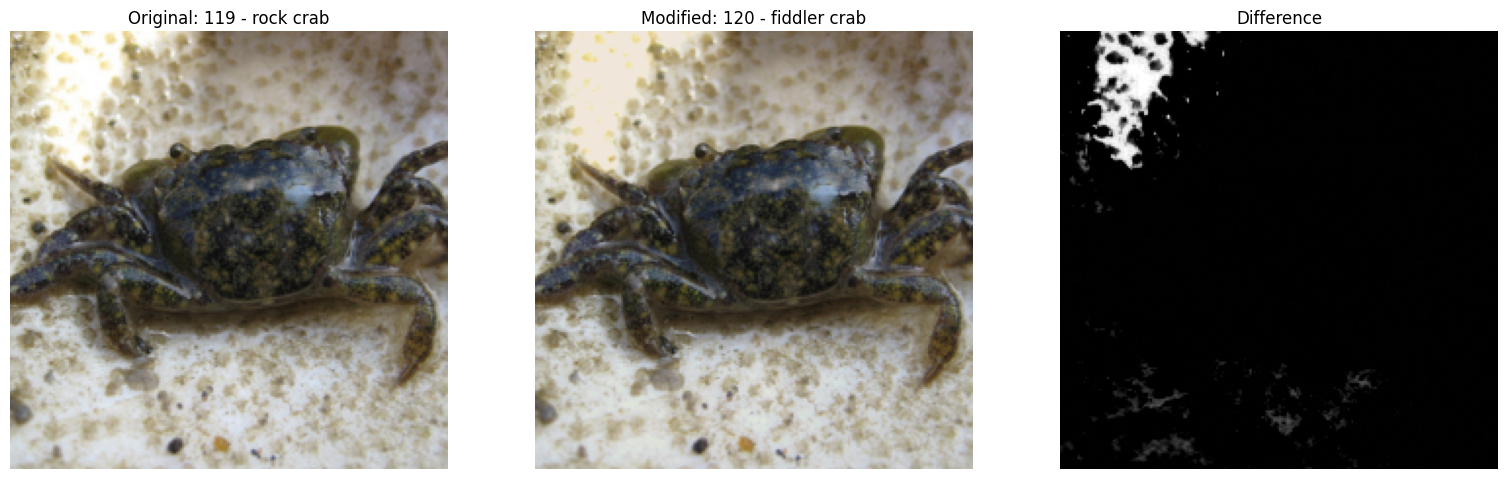

Original prediction: 62
Loss: -16.013568878173828
Loss: -14.518516540527344
Loss: -13.07662582397461
Loss: -11.648284912109375
Loss: -10.310539245605469
Loss: -9.061417579650879


We fooled the network after 5 iterations!
New prediction: 71


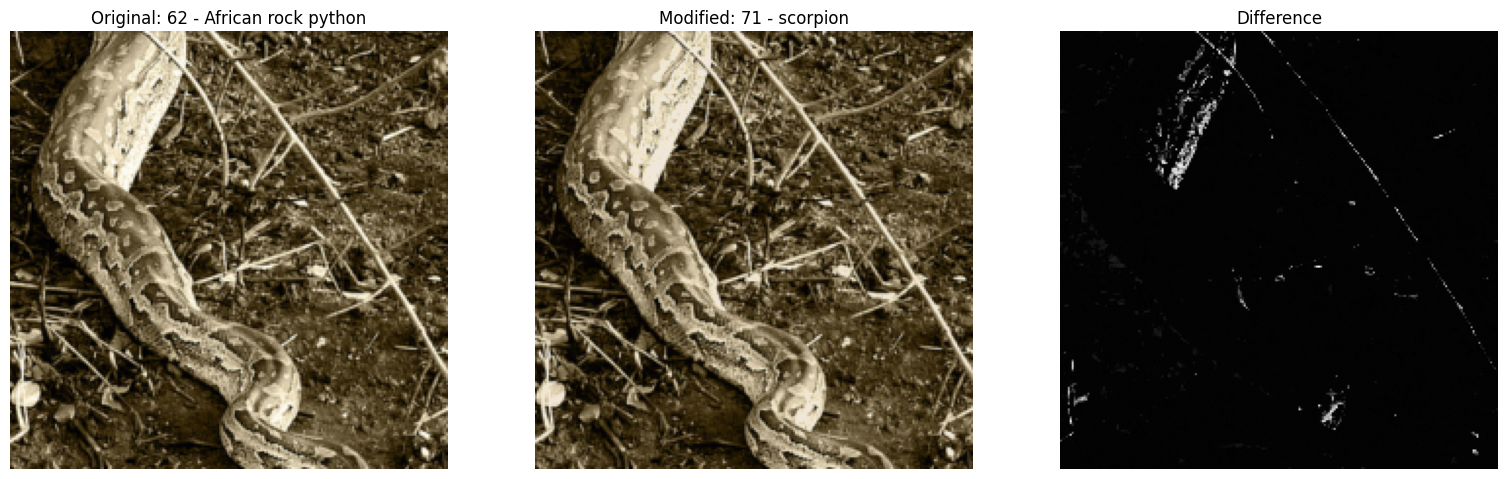

Original prediction: 48
Loss: -15.912260055541992
Loss: -13.949440956115723
Loss: -12.064939498901367
Loss: -10.365089416503906


We fooled the network after 3 iterations!
New prediction: 381


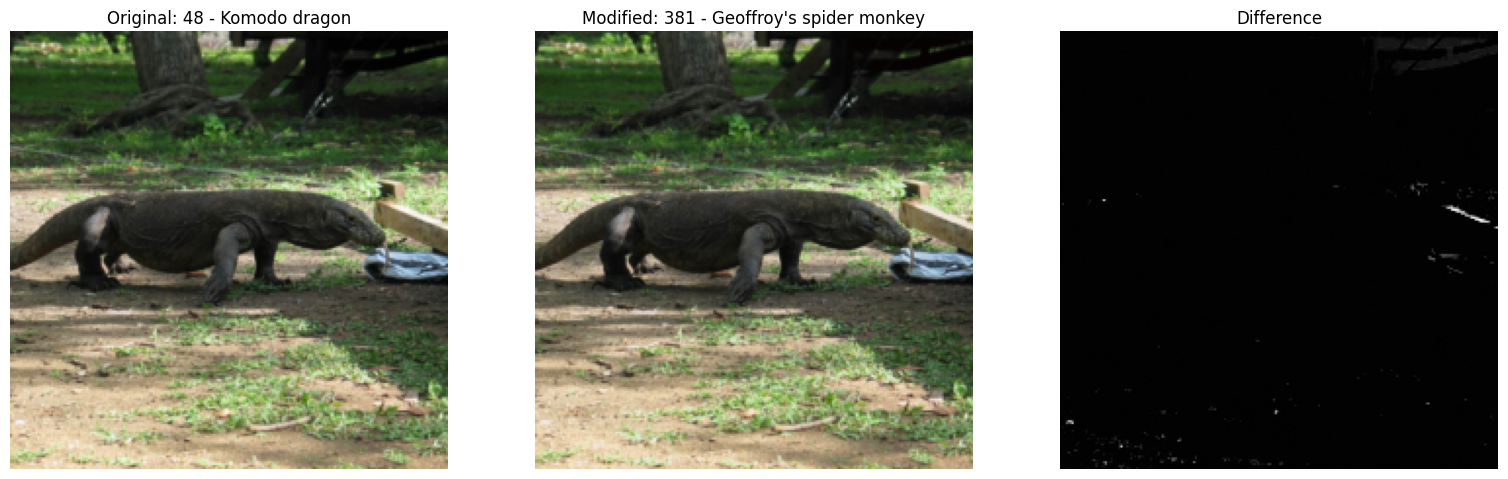

Original prediction: 49
Loss: -18.47939109802246
Loss: -16.0944881439209
Loss: -13.606002807617188
Loss: -11.458612442016602
Loss: -9.591803550720215
We fooled the network after 4 iterations!
New prediction: 460


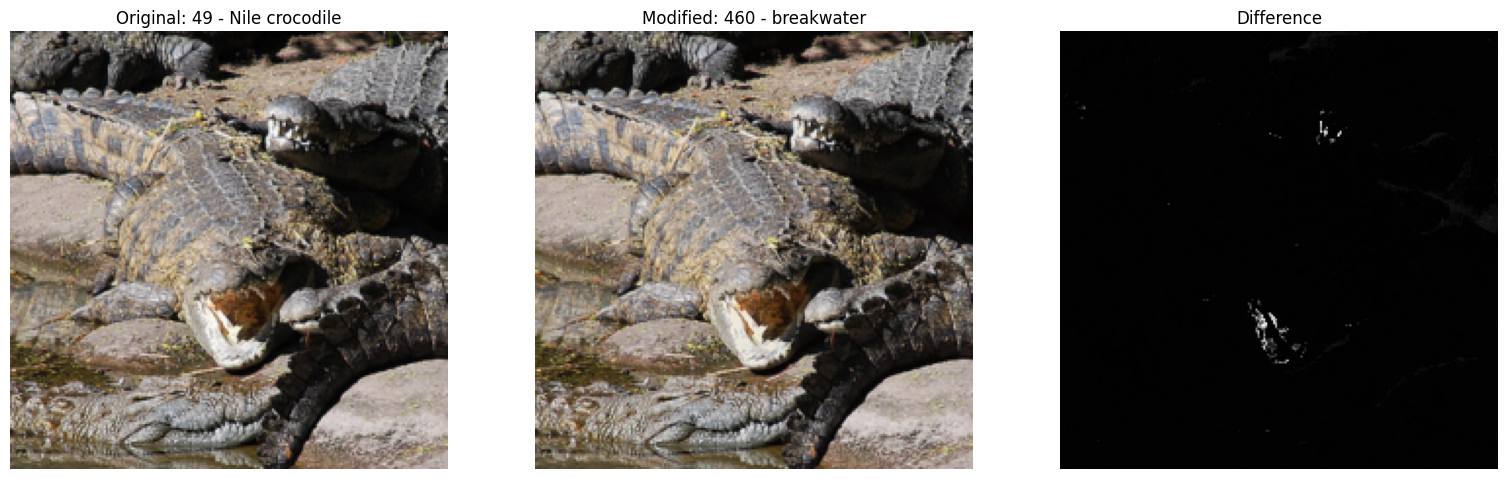

Original prediction: 67
Loss: -23.619932174682617
Loss: -22.4483642578125
Loss: -21.23114013671875
Loss: -20.091766357421875
Loss: -19.01337242126465
Loss: -17.94261360168457
Loss: -16.901613235473633
Loss: -15.909228324890137
Loss: -14.960305213928223
Loss: -14.081277847290039
Loss: -13.255887031555176
Loss: -12.468114852905273
Loss: -11.72551441192627
We fooled the network after 12 iterations!
New prediction: 54


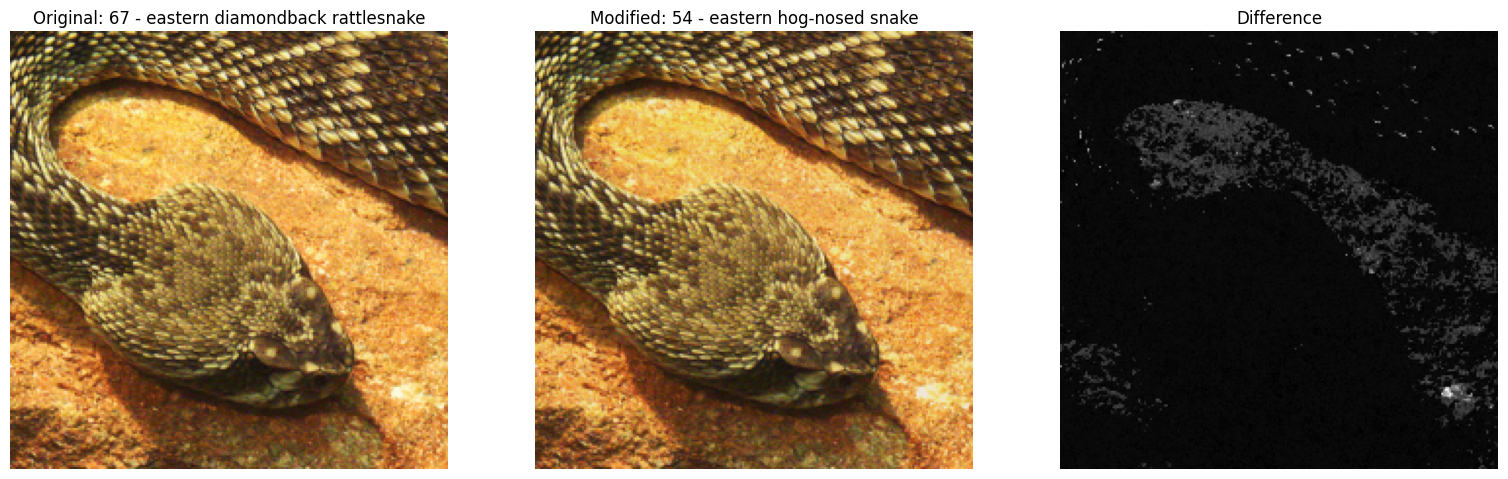

In [5]:
def func(inp, net=None, target=None):
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss

def attack(tensor, net, eps=1e-3, n_iter=50):
    new_tensor = tensor.detach().clone()

    orig_prediction = net(tensor).argmax()
    print(f"Original prediction: {orig_prediction.item()}")

    for i in range(n_iter):
        net.zero_grad()

        grad = compute_gradient(
                func, new_tensor, net=net, target=orig_prediction.item()
                )
        new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_prediction = net(new_tensor).argmax()

        if orig_prediction != new_prediction:
            print(f"We fooled the network after {i} iterations!")
            print(f"New prediction: {new_prediction.item()}")
            break

    return new_tensor, orig_prediction.item(), new_prediction.item()


if __name__ == "__main__":
    net = models.resnet18(pretrained=True)
    net.eval()

    for image_name in image_urls:
        tensor = read_image(image_name)

        new_tensor, orig_prediction, new_prediction = attack(
                tensor, net, eps=1e-3, n_iter=100
                )

        _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))
        arr = to_array(tensor)
        new_arr = to_array(new_tensor)
        diff_arr = np.abs(arr - new_arr).mean(axis=-1)
        diff_arr = diff_arr / diff_arr.max()

        ax_orig.imshow(arr)
        ax_new.imshow(new_arr)
        ax_diff.imshow(diff_arr, cmap="gray")

        ax_orig.axis("off")
        ax_new.axis("off")
        ax_diff.axis("off")

        ax_orig.set_title(f"Original: {orig_prediction} - {class_names[orig_prediction]}")
        ax_new.set_title(f"Modified: {new_prediction} - {class_names[new_prediction]}")
        ax_diff.set_title("Difference")

        plt.show()